<a href="https://colab.research.google.com/github/isralennon/MSAAI530/blob/YAS/USD%2C_IoT%2C_Final_Project%2C_Forecast_future_accelerometer_values%2Ci1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Main Improvements:**

**Most Important Improvement:**
* Subject-level split to avoid data leakage / improve generalizability IRL.

**Overfitting Prevention:**
* Dropout Layers for Regularization
* Early Stopping & Model Checkpoint Callbacks

**Evaluation:**
* MAE, MSE, RMSE

**Saving format**:
* Switched from h5 to newer Keras

---

**Results:**

Previous model had better results, but that's likely due to the change in splittting approach (to subject-wise, to avoid data leakage)

In [ ]:
# Step 1: Download and unzip the dataset
!wget -q https://archive.ics.uci.edu/static/public/780/har70.zip
!unzip -q har70.zip

import os
import glob
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Optional: Enable mixed precision for faster GPU training (if a GPU is available)
if tf.config.list_physical_devices('GPU'):
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision enabled.")

# Parameters
DATA_DIR = "har70plus"
sensor_channel = 'back_x'
train_ratio, val_ratio = 0.70, 0.15
input_window = 50    # Use the past 50 time steps as input
forecast_window = 20 # Forecast the next 20 time steps

# Load & split subject-wise
csv_files = glob.glob(os.path.join(DATA_DIR, "*.csv"))
print(f"Found {len(csv_files)} CSV files.")

# Shuffle files & split by subject
random.shuffle(csv_files)
n_files = len(csv_files)
train_count = int(n_files * train_ratio)
val_count = int(n_files * val_ratio)
train_files = csv_files[:train_count]
val_files = csv_files[train_count: train_count + val_count]
test_files = csv_files[train_count + val_count:]

def load_subject_series(file_list, sensor_channel, input_window, forecast_window):
    series_list = []
    for file in file_list:
        df = pd.read_csv(file)
        # Ensure chronological order
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.sort_values('timestamp')

        # Extract sensor values for channel ('back' for now)
        sensor_values = df[sensor_channel].values
        # Skip series that are too short for window
        if len(sensor_values) < (input_window + forecast_window):
            continue
        series_list.append(sensor_values)
    return series_list

train_series_list = load_subject_series(train_files, sensor_channel, input_window, forecast_window)
val_series_list   = load_subject_series(val_files, sensor_channel, input_window, forecast_window)
test_series_list  = load_subject_series(test_files, sensor_channel, input_window, forecast_window)

# Fit global scaler on training data & create sliding windows
all_train_values = np.concatenate(train_series_list).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(all_train_values)

def create_windows(series_list, input_window, forecast_window, scaler):
    X_windows, y_windows = [], []
    for series in series_list:
        # Scale series using the pre-fitted scaler
        series_scaled = scaler.transform(series.reshape(-1, 1)).flatten()
        # Create sliding windows
        for i in range(len(series_scaled) - input_window - forecast_window + 1):
            x_window = series_scaled[i : i + input_window]
            y_window = series_scaled[i + input_window : i + input_window + forecast_window]
            X_windows.append(x_window)
            y_windows.append(y_window)
    return np.array(X_windows), np.array(y_windows)

# Generate windows for each split
X_train, y_train = create_windows(train_series_list, input_window, forecast_window, scaler)
X_val, y_val     = create_windows(val_series_list, input_window, forecast_window, scaler)
X_test, y_test   = create_windows(test_series_list, input_window, forecast_window, scaler)

# Reshape to (samples, time_steps, features) for univariate series
X_train = X_train.reshape(-1, input_window, 1)
y_train = y_train.reshape(-1, forecast_window, 1)
X_val   = X_val.reshape(-1, input_window, 1)
y_val   = y_val.reshape(-1, forecast_window, 1)
X_test  = X_test.reshape(-1, input_window, 1)
y_test  = y_test.reshape(-1, forecast_window, 1)

print("Training data shape (X):", X_train.shape)
print("Validation data shape (X):", X_val.shape)
print("Test data shape (X):", X_test.shape)

# Create tf.data datasets for optimized GPU training
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Build model w/ TensorFlow/Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Reshape, Dropout

model = Sequential([
    Input(shape=(input_window, 1)),
    LSTM(50, activation='tanh', return_sequences=True),
    Dropout(0.2),  # Added dropout to help reduce overfitting
    LSTM(30, activation='tanh'),
    Dropout(0.2),  # Added dropout after the second LSTM
    Dense(forecast_window),
    Reshape((forecast_window, 1))
])

model.compile(optimizer='adam', loss='mse')

# Display model summary
model.summary()

# Define callbacks for training (Additional Callbacks for Training)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

# Train model with callbacks
EPOCHS = 20
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks=callbacks)

# Evaluate model on test set
test_loss = model.evaluate(test_ds)
print("Test Loss:", test_loss)


Mixed precision enabled.
Found 18 CSV files.
Training data shape (X): (1439086, 50, 1)
Validation data shape (X): (261701, 50, 1)
Test data shape (X): (557568, 50, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30)                  │           9,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │             620 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 20, 1)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,740 (81.02 KB)

 Trainable params: 20,740 (81.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
22486/22486 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0055

22486/22486 ━━━━━━━━━━━━━━━━━━━━ 200s 9ms/step - loss: 0.0055 - val_loss: 7.1398e-04
Epoch 2/20
22486/22486 ━━━━━━━━━━━━━━━━━━━━ 193s 9ms/step - loss: 5.7010e-04 - val_loss: 7.4134e-04
Epoch 3/20
22486/22486 ━━━━━━━━━━━━━━━━━━━━ 193s 9ms/step - loss: 5.2627e-04 - val_loss: 7.3996e-04
Epoch 4/20
22486/22486 ━━━━━━━━━━━━━━━━━━━━ 194s 9ms/step - loss: 5.0962e-04 - val_loss: 7.7032e-04
Epoch 5/20
22486/22486 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9905e-04

22486/22486 ━━━━━━━━━━━━━━━━━━━━ 194s 9ms/step - loss: 4.9905e-04 - val_loss: 7.0195e-04
Epoch 6/20
22486/22486 ━━━━━━━━━━━━━━━━━━━━ 194s 9ms/step - loss: 4.9408e-04 - val_loss: 7.1541e-04
Epoch 7/20
22481/22486 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8950e-04

22486/22486 ━━━━━━━━━━━━━━━━━━━━ 194s 9ms/step - loss: 4.8952e-04 - val_loss: 6.9450e-04
Epoch 8/20
22480/22486 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8333e-04

22486/22486 ━━━━━━━━━━━━━━━━━━━━ 194s 9ms/step - loss: 4.8334e-04 - val_loss: 6.8752e-04
Epoch 9/20
22482/22486 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8396e-04

22486/22486 ━━━━━━━━━━━━━━━━━━━━ 195s 9ms/step - loss: 4.8397e-04 - val_loss: 6.6408e-04
Epoch 10/20
22484/22486 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7974e-04

22486/22486 ━━━━━━━━━━━━━━━━━━━━ 195s 9ms/step - loss: 4.7975e-04 - val_loss: 6.3599e-04
Epoch 11/20
22481/22486 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7876e-04

22486/22486 ━━━━━━━━━━━━━━━━━━━━ 195s 9ms/step - loss: 4.7877e-04 - val_loss: 6.3079e-04
Epoch 12/20
22481/22486 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8253e-04

22486/22486 ━━━━━━━━━━━━━━━━━━━━ 195s 9ms/step - loss: 4.8254e-04 - val_loss: 6.2698e-04
Epoch 13/20
22486/22486 ━━━━━━━━━━━━━━━━━━━━ 195s 9ms/step - loss: 4.7725e-04 - val_loss: 6.4331e-04
Epoch 14/20
22486/22486 ━━━━━━━━━━━━━━━━━━━━ 195s 9ms/step - loss: 4.7693e-04 - val_loss: 6.3905e-04
Epoch 15/20
22486/22486 ━━━━━━━━━━━━━━━━━━━━ 196s 9ms/step - loss: 4.7300e-04 - val_loss: 6.3559e-04
Epoch 16/20
22486/22486 ━━━━━━━━━━━━━━━━━━━━ 196s 9ms/step - loss: 4.7046e-04 - val_loss: 6.5581e-04
Epoch 17/20
22486/22486 ━━━━━━━━━━━━━━━━━━━━ 196s 9ms/step - loss: 4.9446e-04 - val_loss: 6.8486e-04
8712/8712 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 9.5767e-04
Test Loss: 0.0014575774548575282


17424/17424 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step


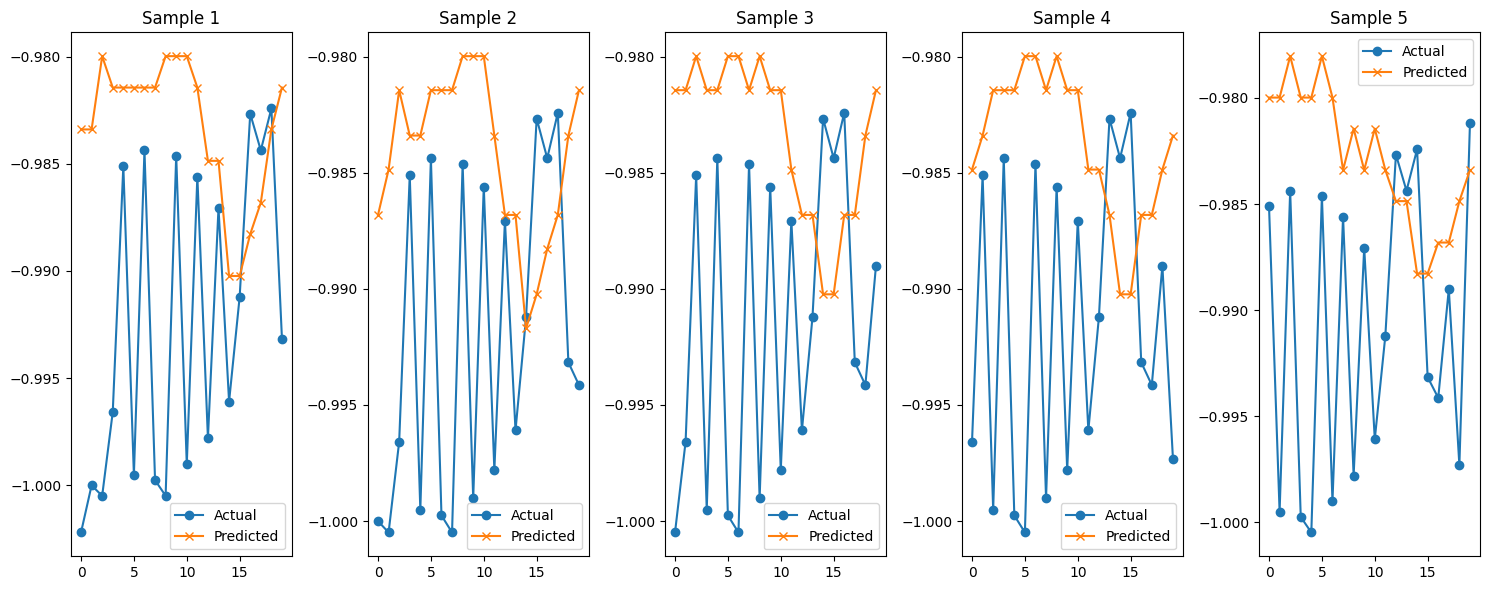

17424/17424 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step
Mean Absolute Error (MAE): 0.0784
Mean Squared Error (MSE): 0.0179
Root Mean Squared Error (RMSE): 0.1337
Mounted at /content/drive
Model saved to: /content/drive/My Drive/my_model.keras


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import os

# Generate predictions & visualize
def plot_predictions(model, X_test, y_test, scaler, num_samples=5):
    """
    Plot predictions vs actuals for a few samples from the test set.
    """
    preds = model.predict(X_test)  # Predict on test set
    preds = preds.reshape(-1, forecast_window)
    y_test = y_test.reshape(-1, forecast_window)

    # Inverse transform the predictions and actual values
    preds_inv = scaler.inverse_transform(preds)
    y_test_inv = scaler.inverse_transform(y_test)

    plt.figure(figsize=(15, 6))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.plot(y_test_inv[i], label="Actual", marker='o')
        plt.plot(preds_inv[i], label="Predicted", marker='x')
        plt.legend()
        plt.title(f"Sample {i+1}")
    plt.tight_layout()
    plt.show()

# Plot some test samples
plot_predictions(model, X_test, y_test, scaler)

# Compute evaluation metrics
def evaluate_model(model, X_test, y_test, scaler):
    """
    Evaluate the model on test data with additional metrics.
    """
    preds = model.predict(X_test)
    preds = preds.reshape(-1, forecast_window)
    y_test = y_test.reshape(-1, forecast_window)

    # Inverse transform predictions
    preds_inv = scaler.inverse_transform(preds)
    y_test_inv = scaler.inverse_transform(y_test)

    # Compute errors
    mae = mean_absolute_error(y_test_inv, preds_inv)
    mse = mean_squared_error(y_test_inv, preds_inv)
    rmse = math.sqrt(mse)

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Run evaluation
evaluate_model(model, X_test, y_test, scaler)

# Save model to Drive
from google.colab import drive
drive.mount('/content/drive')
model_save_path = "/content/drive/My Drive/my_model.keras"
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")